In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
#warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/hong/anaconda2/envs/python36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## New transactions

In [2]:
new_transactions = pd.read_csv('Downloads/all/new_merchant_transactions.csv')
new_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [3]:
new_transactions['authorized_flag'] = \
    new_transactions['authorized_flag'].map({'Y':1, 'N':0})

### transfer into number & expand aggregate(sum median max min std ...)

In [4]:
def aggregate_new_transactions(new_trans):    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'month_lag': ['min', 'max']
        }
    agg_new_trans = new_trans.groupby(['card_id']).agg(agg_func)
    agg_new_trans.columns = ['new_' + '_'.join(col).strip() 
                           for col in agg_new_trans.columns.values]
    agg_new_trans.reset_index(inplace=True)
    
    df = (new_trans.groupby('card_id')
          .size()
          .reset_index(name='new_transactions_count'))
    
    agg_new_trans = pd.merge(df, agg_new_trans, on='card_id', how='left')
    
    return agg_new_trans

new_trans = aggregate_new_transactions(new_transactions)
new_trans[:10]

,card_id,new_transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_merchant_id_nunique,new_city_id_nunique,new_purchase_amount_sum,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,2,1,2,2,-1.328524,-0.664262,-0.656749,-0.671775,0.010625,2,1.0,1,1,0.000000,2,2
1,C_ID_0001238066,26,26,1,25,8,-14.850055,-0.649235,-0.078318,-0.740897,0.173436,42,1.0,10,-1,2.079941,1,2
2,C_ID_0001506ef0,2,2,1,1,1,-1.447354,-0.723677,-0.715352,-0.732001,0.011773,0,0.0,0,0,0.000000,1,1
3,C_ID_0001793786,31,31,1,31,7,-0.229620,-0.372748,3.129932,-0.737892,0.947223,0,0.0,0,0,0.000000,1,2
4,C_ID_000183fdda,11,11,1,11,2,-6.590778,-0.665765,-0.107680,-0.732332,0.182877,16,1.0,4,-1,1.293340,1,2
5,C_ID_0002709b5a,3,3,1,3,3,-2.018827,-0.680791,-0.611669,-0.726367,0.057750,1,1.0,1,-1,1.154701,1,2
6,C_ID_000298032a,1,1,1,1,1,-0.641872,-0.641872,-0.641872,-0.641872,NaN,0,0.0,0,0,NaN,2,2
7,C_ID_0002ba3c2e,3,3,1,3,1,-2.071059,-0.697561,-0.667883,-0.705615,0.019872,0,0.0,0,0,0.000000,1,2
8,C_ID_0002c7c2c1,6,6,1,6,3,-3.929448,-0.671324,-0.497768,-0.731881,0.083328,0,0.0,0,0,0.000000,1,2
9,C_ID_00032df08f,8,8,1,7,1,-2.791535,-0.478579,0.449203,-0.640520,0.366423,8,1.0,1,1,0.000000,2,2


## historical_transactions

In [5]:
historical_transactions = pd.read_csv('Downloads/all/historical_transactions.csv')
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [6]:
historical_transactions['authorized_flag'] = \
    historical_transactions['authorized_flag'].map({'Y':1, 'N':0})
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
historical_transactions['category_1'] = historical_transactions['category_1'].map({'Y': 1, 'N': 0})
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,1,0,0,0,0,1,0,0


In [7]:
def aggregate_historical_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

history = aggregate_historical_transactions(historical_transactions)
history[:10]


,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,...,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max
0,C_ID_4e6213e9bc,1,1,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,...,-0.703331,NaN,0,0.000000,0,0,NaN,0.0,-8,-8
1,C_ID_00007093c1,149,114,0.765101,0.187919,0.000000,0.000000,0.805369,0.0,0.006711,...,-0.728876,0.298141,192,1.288591,6,1,0.764900,32627654.0,-12,0
2,C_ID_0001238066,123,120,0.975610,0.016260,0.772358,0.000000,0.000000,0.0,0.162602,...,-0.734887,0.190235,198,1.609756,10,-1,1.485637,13110825.0,-5,0
3,C_ID_0001506ef0,66,62,0.939394,0.000000,0.030303,0.000000,0.969697,0.0,0.000000,...,-0.740491,0.472284,1,0.015152,1,0,0.123091,34460275.0,-13,0
4,C_ID_0001793786,216,189,0.875000,0.009259,0.050926,0.351852,0.069444,0.0,0.000000,...,-0.745405,0.836046,5,0.023148,1,0,0.150723,24487497.0,-9,0
5,C_ID_000183fdda,144,137,0.951389,0.027778,0.048611,0.006944,0.909722,0.0,0.006944,...,-0.737892,0.524948,264,1.833333,10,-1,2.118846,17492874.0,-6,0
6,C_ID_00024e244b,70,53,0.757143,0.000000,0.042857,0.000000,0.957143,0.0,0.000000,...,-0.740897,0.416742,5,0.071429,1,0,0.259399,34540529.0,-13,0
7,C_ID_0002709b5a,73,67,0.917808,0.082192,0.013699,0.712329,0.000000,0.0,0.191781,...,-0.727388,0.078777,129,1.767123,12,-1,2.182764,34738297.0,-13,0
8,C_ID_00027503e2,42,24,0.571429,0.000000,0.071429,0.000000,0.928571,0.0,0.000000,...,-0.745871,0.003334,0,0.000000,0,0,0.000000,20483171.0,-8,0
9,C_ID_000298032a,30,28,0.933333,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,...,-0.719529,0.589542,0,0.000000,0,0,0.000000,29831230.0,-11,0


In [84]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['year'] = df['first_active_month'].dt.year
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    df['constant']=1
    return df
train = read_data('Downloads/all/train.csv')
test = read_data('Downloads/all/test.csv')

target = train['target']
#del train['target']

## Merge historical transactions and new transactions

In [85]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, new_trans, on='card_id', how='left')
test = pd.merge(test, new_trans, on='card_id', how='left')



In [86]:
correlation=train.corr()
correlation=abs(correlation)
correlation['target'].sort_values(ascending=False)
# type(abs(correlation['target']))
correlation['target']['elapsed_time']
use_cols = [col for col in train.columns if col not in ['card_id', 'first_active_month','constant']]
use_cols_t = [col for col in train.columns if col not in ['card_id', 'first_active_month','constant','target']]
for col in use_cols :
    train[col]=train[col] * correlation['target'][col] *20
for col in use_cols_t :
    test[col] = test[col] * correlation['target'][col] *20
train[:10]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,elapsed_time,constant,...,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new_month_lag_min,new_month_lag_max
0,2017-06-01,C_ID_92a2005557,1.425105,0.249671,0.162506,-16.405652,1627.370055,3.781484,247.220516,1,...,-0.386268,-0.403100,0.176696,0.000000,0.000000,0.000000,0.00000,0.000000,1.141694,1.330891
1,2017-01-01,C_ID_3d0044924f,1.140084,0.124835,0.000000,7.858265,1627.370055,0.630247,399.589078,1,...,-0.915548,-0.411470,0.018639,4.278205,0.713195,0.747747,0.25343,0.000000,1.141694,1.330891
2,2016-08-01,C_ID_d639edf6cd,0.570042,0.249671,0.000000,13.761120,1626.563228,5.041979,553.975768,1,...,-0.913549,-0.389721,NaN,0.000000,0.000000,0.000000,0.00000,NaN,2.283387,1.330891
3,2017-09-01,C_ID_186d6a6901,1.140084,0.374506,0.000000,2.849904,1627.370055,5.672226,154.386689,1,...,-0.739291,-0.408535,0.085715,3.565171,0.713195,0.747747,-0.25343,0.645774,1.141694,1.330891
4,2017-11-01,C_ID_cdbd2c0db2,0.285021,0.374506,0.000000,-3.194984,1627.370055,6.932721,92.833826,1,...,0.588164,-0.411462,0.291200,24.956196,0.713195,1.495494,-0.25343,0.321989,1.141694,1.330891
5,2016-09-01,C_ID_0894217f2f,1.140084,0.249671,0.000000,17.431706,1626.563228,5.672226,522.694805,1,...,-0.000118,-0.364216,0.364748,7.843376,1.782987,3.738734,0.25343,1.458958,1.141694,1.330891
6,2016-12-01,C_ID_7e63323c00,0.855063,0.249671,0.162506,4.602580,1626.563228,7.562968,430.870042,1,...,-0.897927,-0.412925,0.025508,0.000000,0.000000,0.000000,0.00000,0.000000,1.141694,1.330891
7,2017-09-01,C_ID_dfa21fc124,0.855063,0.249671,0.162506,42.716995,1627.370055,5.672226,154.386689,1,...,-0.909629,-0.390557,0.002949,0.000000,0.000000,0.000000,0.00000,0.000000,2.283387,1.330891
8,2017-08-01,C_ID_fe0fdac8ea,0.570042,0.124835,0.000000,-1.308128,1627.370055,5.041979,185.667653,1,...,-0.757521,-0.379770,0.093588,1.426068,0.713195,0.747747,0.25343,0.000000,1.141694,0.665445
9,2016-08-01,C_ID_bf62c0b49d,0.570042,0.249671,0.000000,6.001234,1626.563228,5.041979,553.975768,1,...,-0.869054,-0.412716,0.053552,0.000000,0.000000,0.000000,0.00000,0.000000,2.283387,1.330891


In [87]:
del train['target']

## Feature preparation

In [88]:
use_cols = [col for col in train.columns if col not in ['card_id', 'first_active_month']]
train = train[use_cols]
test = test[use_cols]

In [23]:
features = list(train[use_cols].columns)
categorical_feats = [col for col in features if 'feature_' in col]
for col in categorical_feats:
    print(col, 'have', train[col].value_counts().shape[0], 'categories.')

feature_1 have 5 categories.
feature_2 have 3 categories.
feature_3 have 2 categories.


In [24]:
from sklearn.preprocessing import LabelEncoder
for col in categorical_feats:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))
    


feature_1
feature_2
feature_3


In [89]:
df_all = pd.concat([train, test])
#df_all = pd.get_dummies(df_all, columns=categorical_feats)
df_all.fillna(axis=0, method='ffill', inplace=True)
df_all.fillna(value=0, inplace=True)

len_train = train.shape[0]

train = df_all[:len_train]
test = df_all[len_train:]
np.where(np.isnan(df_all))

(array([], dtype=int64), array([], dtype=int64))

# LGB

In [90]:
from sklearn import linear_model

clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(train, target)
theta = clf.coef_
predictions = clf.predict(test)
predictions[:10]

/Users/hong/anaconda2/envs/python36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.119744e-19
  overwrite_a=True).T


array([-0.98696175, -0.44322403, -0.86214207,  0.1193639 , -2.4730313 ,
       -0.34676216,  0.03872532, -0.57846415, -2.10782112, -1.02481133])

In [20]:
lgb_params = {"objective" : "regression", "metric" : "rmse", 
               "max_depth": 7, "min_child_samples": 20, 
               "reg_alpha": 1, "reg_lambda": 1,
               "num_leaves" : 64, "learning_rate" : 0.001, 
               "subsample" : 0.8, "colsample_bytree" : 0.8, 
               "verbosity": -1}

FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

features_lgb = list(train.columns)
feature_importance_df_lgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])

    print("LGB " + str(fold_) + "-" * 50)
    num_round = 2000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 2000)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df_lgb = pd.DataFrame()
    fold_importance_df_lgb["feature"] = features_lgb
    fold_importance_df_lgb["importance"] = clf.feature_importance()
    fold_importance_df_lgb["fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([feature_importance_df_lgb, fold_importance_df_lgb], axis=0)
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / FOLDs.n_splits
    

print(np.sqrt(mean_squared_error(oof_lgb, target)))

LGB 0--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.7951	valid_1's rmse: 3.89481
[400]	training's rmse: 3.76645	valid_1's rmse: 3.87251
[600]	training's rmse: 3.74419	valid_1's rmse: 3.85659
[800]	training's rmse: 3.72554	valid_1's rmse: 3.84394
[1000]	training's rmse: 3.71017	valid_1's rmse: 3.83441
[1200]	training's rmse: 3.69594	valid_1's rmse: 3.82626
[1400]	training's rmse: 3.68378	valid_1's rmse: 3.81973
[1600]	training's rmse: 3.67289	valid_1's rmse: 3.81441
[1800]	training's rmse: 3.6631	valid_1's rmse: 3.81024
[2000]	training's rmse: 3.65375	valid_1's rmse: 3.80615
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.65375	valid_1's rmse: 3.80615
LGB 1--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.82747	valid_1's rmse: 3.76429
[400]	training's rmse: 3.7987	valid_1's rmse: 3

In [92]:
sub_df = pd.read_csv('Downloads/all/sample_submission.csv')
# sub_df["target"] = predictions_lgb
sub_df["target"] = predictions
sub_df.to_csv("Downloads/all/submission_allfeatures_reg_weight2.csv", index=False)

/Users/hong/anaconda2/envs/python36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


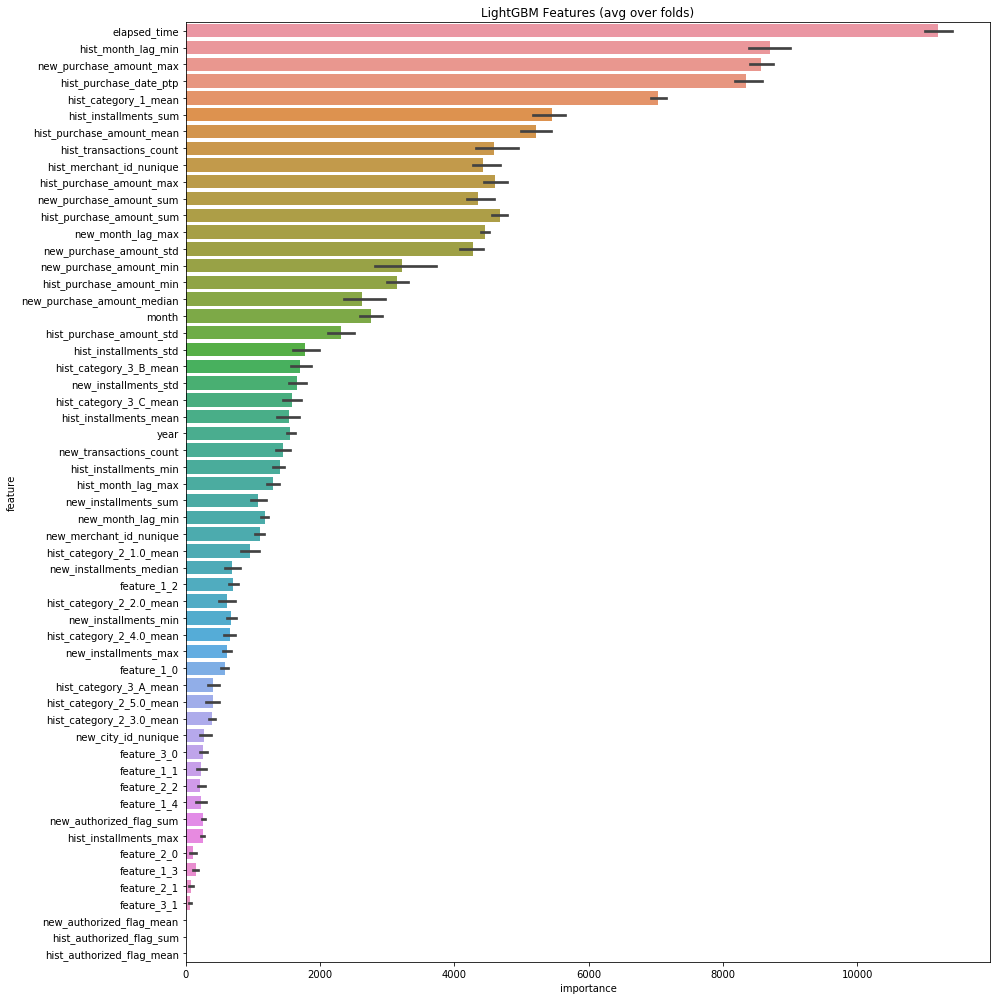

In [23]:
cols = (feature_importance_df_lgb[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_lgb.loc[feature_importance_df_lgb.feature.isin(cols)]

plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [7]:
clear